In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn.model_selection import train_test_split
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import random

D:\Anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
Model_test_Dataset = pd.read_csv('Test Data\\Curated_Test_Data.csv')

Dataset_list = [Model_test_Dataset]

In [5]:
def Feature_Label_Extraction(df_in,num_of_examples = 4200):
    df_out = df_in[0:num_of_examples]
    df_out_feature = df_out.iloc[:,:832]
    
    white_elos = df_out["White ELO"].astype(int)
    black_elos = df_out["Black ELO"].astype(int)
    avg_elos = np.mean([np.array(white_elos),np.array(black_elos)],axis=0)
    
    df_out_label = pd.DataFrame(columns = ["Average ELO"])
    df_out_label["Average ELO"] = avg_elos
    
    #df_out_label = white_elos
    return df_out_feature , df_out_label
    
def Prepare_Datasets(dataset_list):
    out_df_feature = pd.DataFrame()
    out_df_label = pd.DataFrame()
    for dataframe in dataset_list:
        feature , label = Feature_Label_Extraction(dataframe)
        out_df_feature = out_df_feature.append(feature,ignore_index=True)
        #out_df_label = out_df_label.append(label,ignore_index = True)
        out_df_label = pd.concat([out_df_label,label])
    return out_df_feature , out_df_label


def Hot_1_encoder(df_in):
    New_array = np.zeros([df_in.shape[0],df_in.shape[1]*13])
    for i in range(df_in.shape[0]):
        for j,val in enumerate(df_in.iloc[i][:]):
            New_array[i,13*j+int(val)] = 1
            
    return New_array

In [6]:
trainx, trainy = Prepare_Datasets(Dataset_list)

In [7]:
#Load the agnostic model
Test_model = keras.models.load_model('Models_middlegame_expanded_ELO')

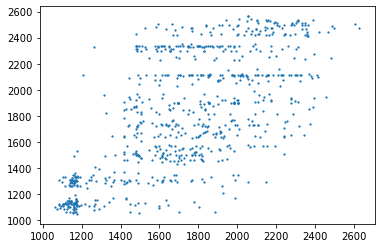

In [8]:
x_pred = Test_model.predict_on_batch(trainx)*1599 + 1000
ax =plt.scatter(x_pred,trainy,s=1.5)
plt.xlim = ([800,2600])
plt.ylim = ([800,2600])
x_pred = x_pred.flatten().tolist()


In [9]:
max(Test_model.predict_on_batch(trainx))

array([1.0165135], dtype=float32)

In [10]:
pred_real = list(zip(trainy.transpose()[0],x_pred))

In [11]:
def Build_Brackets(real_elo):
    bracket_dict = {
        0 : '1000-1199',
        1 : '1200-1399',
        2 : '1400-1599',
        3 : '1600-1799',
        4 : '1800-1999', 
        5 : '2000-2199',
        6 : '2200-2399',
        7 : '2400-2599',
        8 : '2600 +'
        }
    key = (int(real_elo)-1000)//200
    return bracket_dict.get(key)

In [12]:
trainy

,Average ELO
0,1117.0
1,1061.0
2,1062.0
3,1084.5
4,1192.0
...,...
795,2422.5
796,2421.0
797,2420.0
798,2423.5


In [13]:
trainy.transpose().head()
Build_Brackets(trainy['Average ELO'].loc[0])

'1000-1199'

In [14]:
pred_real_df = pd.DataFrame()
pred_real_df["Real ELO"] = trainy["Average ELO"]
pred_real_df["Predicted ELO"] = x_pred
pred_real_df["ELO Bracket"] = trainy["Average ELO"].astype(int).apply(lambda x:Build_Brackets(x))
pred_real_df["Pred ELO Bracket"] = [Build_Brackets(i) for i in x_pred]


In [15]:
Predictions = pd.DataFrame()
Pred_only = pd.DataFrame()
True_only = pd.DataFrame()
ELO_bracket = ['1000-1199','1200-1399','1400-1599','1600-1799','1800-1999','2000-2199','2200-2399']
ELO_bracket_num = [[1000,1199],[1200,1399],[1400,1599],[1600,1799],[1800,1999],[2000,2199],[2200,2399]]
Pred_dict = dict()
for i in range(len(ELO_bracket)):
    Predictions['true ELO ' + ELO_bracket[i]] = pred_real_df["Real ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                                         (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    Predictions['pred ELO ' + ELO_bracket[i]] = pred_real_df["Predicted ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                            (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    Pred_only['pred ELO ' + ELO_bracket[i]] =  pred_real_df["Predicted ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                            (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    True_only['true ELO ' + ELO_bracket[i]] = pred_real_df["Real ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                                         (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    
    Pred_dict[ELO_bracket[i]] = pred_real_df[(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]

In [16]:
test =  pred_real_df[(pred_real_df["Real ELO"]>ELO_bracket_num[0][0]) & (pred_real_df["Real ELO"]<ELO_bracket_num[0][1])]

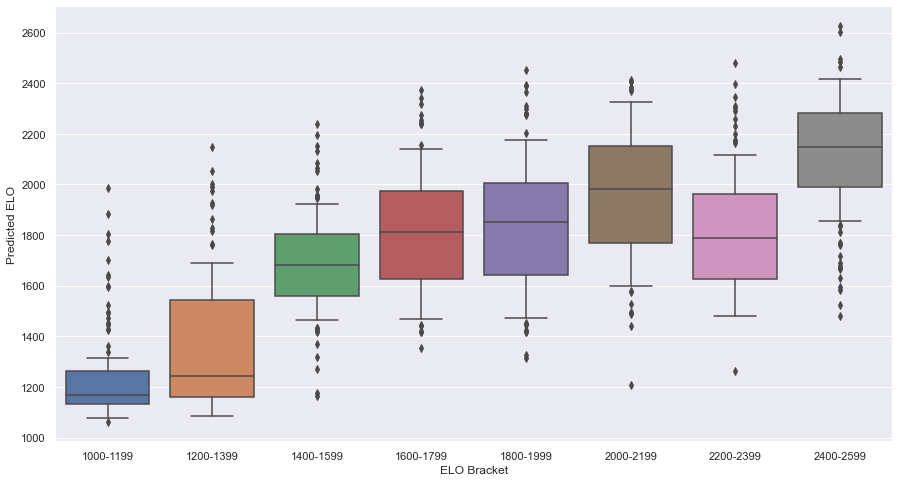

In [32]:
x = list(Pred_dict.keys())
ax = sns.boxplot(x = "ELO Bracket", y = "Predicted ELO" , data = pred_real_df.sort_values(by = ["ELO Bracket"]), whis = 0.5)

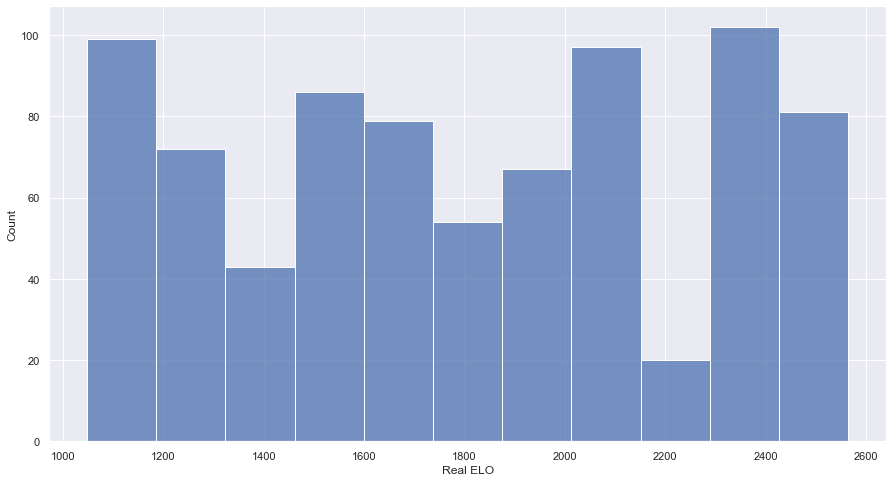

In [18]:
sns.set(rc = {'figure.figsize':(15,8)})
plot = sns.histplot(data = pred_real_df["Real ELO"])


In [19]:
def Accuracy(df_in):
    #Calculate how often the model successfully classifies a game in a given ELO bracket
    brackets = [[i,i+199] for i in [1000,1200,1400,1600,1800,2000,2200]]
    accuracy = []
    colnames = list(df_in.columns)
    for i in range(len(df_in.columns)):
        count = 0
        for j in df_in.loc[:,colnames[i]]:
            if j>=brackets[i][0] and j<=brackets[i][1]:
                count += 1    
        accuracy.append(count/len(df_in.loc[:,colnames[i]]))
    return accuracy

Text(0, 0.5, 'Accuracy')

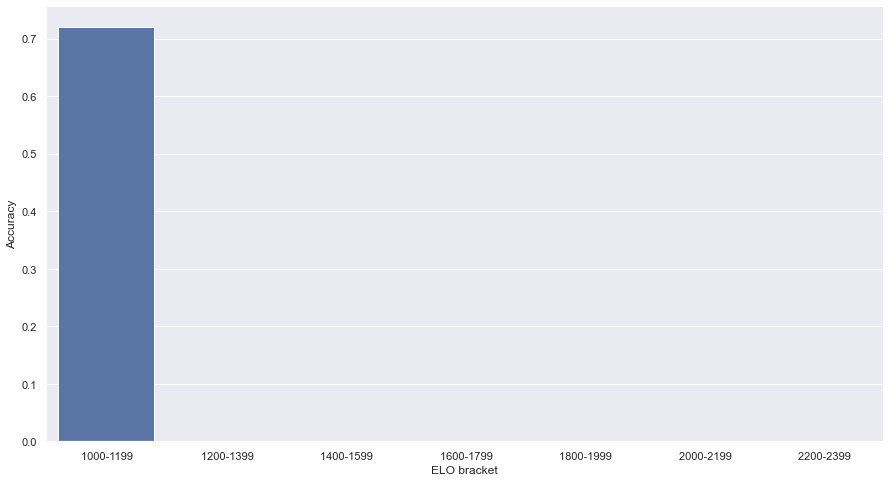

In [20]:
acc = Accuracy(Pred_only)
acc_labels = list(Pred_only.columns)
for i,item in enumerate(acc_labels):
    acc_labels[i] = item.split("ELO",1)[1]

acc_plot = sns.barplot(x = acc_labels , y = acc)

acc_plot.set_xlabel('ELO bracket')
acc_plot.set_ylabel('Accuracy')


In [21]:
def MSE(pred_df,true_df):
    MSE_list = []
    total_SE = 0
    count = 0
    pred_cols = list(pred_df.columns)
    true_cols = list(true_df.columns)
    
    for i in range(len(pred_cols)):
        SE = 0
        for j in range(len(pred_df.loc[:,pred_cols[i]])):
            SE += (pred_df.loc[j,pred_cols[i]] - true_df.loc[j,true_cols[i]])**2
            count += 1
        MSE_list .append(np.sqrt(SE/len(pred_df.loc[:,pred_cols[i]])))
        total_SE += SE
    total_MSE = total_SE/count
    
    return MSE_list , total_MSE

In [22]:
def ROCgression(real_vals,pred_vals):
    real = np.array(real_vals,dtype=int)
    pred = np.array(pred_vals,dtype=int)
    difference = abs(real-pred)
    
    
    ROC_curve = np.zeros(max(difference)+1)
    
    for i in difference:
        ROC_curve[i] += 1
        
    for i in range(1,len(ROC_curve)):
        ROC_curve[i] += ROC_curve[i-1]
        
    ROC_curve = np.divide(ROC_curve,len(difference))
    
    return ROC_curve

In [23]:
random_array = np.random.randint(pred_real_df["Real ELO"].min(),
                          high = pred_real_df["Real ELO"].max(),
                         size = np.shape(pred_real_df["Real ELO"]))

In [24]:
Model_ROC = ROCgression(pred_real_df["Real ELO"],pred_real_df["Predicted ELO"])
Random_ROC = ROCgression(pred_real_df["Real ELO"],random_array)

In [25]:
ROC_dict = {'Model_ROC': Model_ROC,
           'Random_Roc': Random_ROC}

[Text(0, 0.5, 'Fraction of Dataset')]

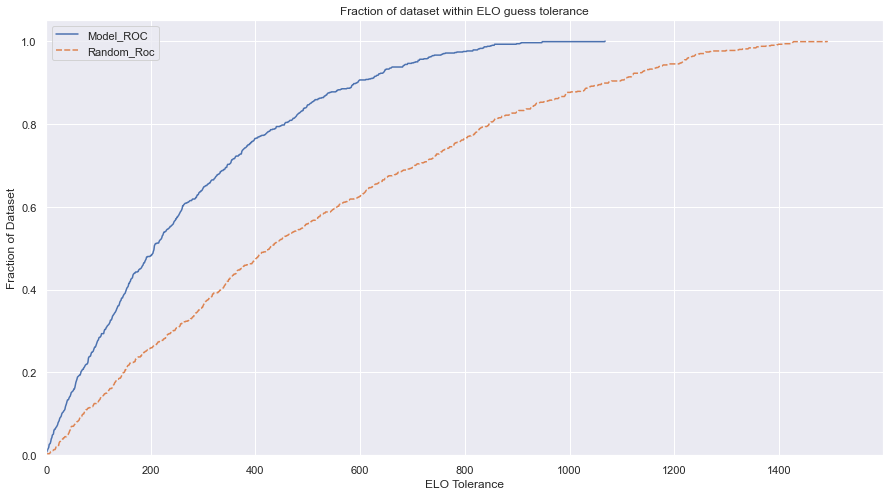

In [26]:
ax = sns.lineplot(data = ROC_dict)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set(title = 'Fraction of dataset within ELO guess tolerance')
ax.set(xlabel = 'ELO Tolerance')
ax.set(ylabel = 'Fraction of Dataset')
#plt.xlim(0,1200)

In [27]:
ROC_Classified_Dict = {}
for label in pred_real_df["ELO Bracket"].unique():
    sliced = pred_real_df.loc[pred_real_df["ELO Bracket"] == label]
    ROC_Classified_Dict[label] = ROCgression(sliced["Real ELO"],sliced["Predicted ELO"])
    
ROC_Classified_Dict["Random Guess"] = ROC_dict["Random_Roc"]

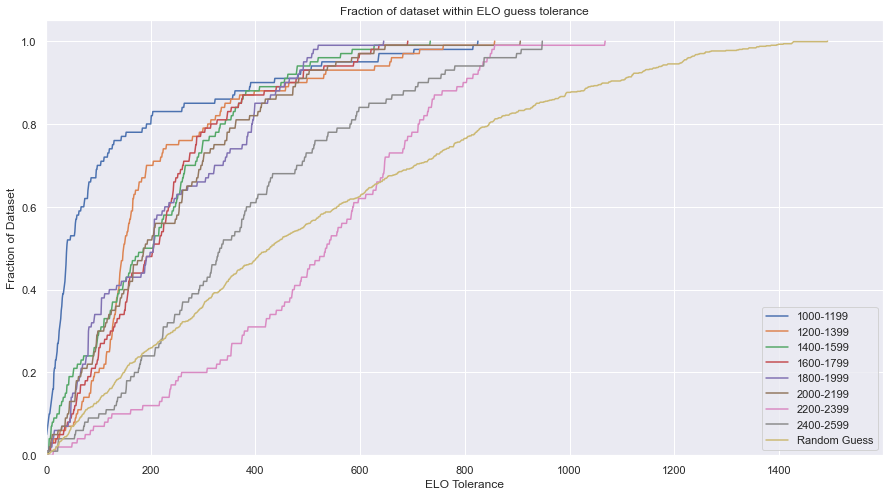

In [28]:
ax = sns.lineplot(data = ROC_Classified_Dict,dashes=False)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set(title = 'Fraction of dataset within ELO guess tolerance')
ax.set(xlabel = 'ELO Tolerance')
ax.set(ylabel = 'Fraction of Dataset')
ax.legend(loc='lower right')

In [29]:
ROC_Pred_Classified_Dict = {}
for label in pred_real_df["Pred ELO Bracket"].unique():
    sliced = pred_real_df.loc[pred_real_df["Pred ELO Bracket"] == label]
    ROC_Pred_Classified_Dict[label] = ROCgression(sliced["Real ELO"],sliced["Predicted ELO"])
    #print(len(sliced),label)
    #if len(sliced) < 10:
    #    print('popping')
    #    ROC_Pred_Classified_Dict.pop(label)
    
ROC_Pred_Classified_Dict["Random Guess"] = ROC_dict["Random_Roc"]

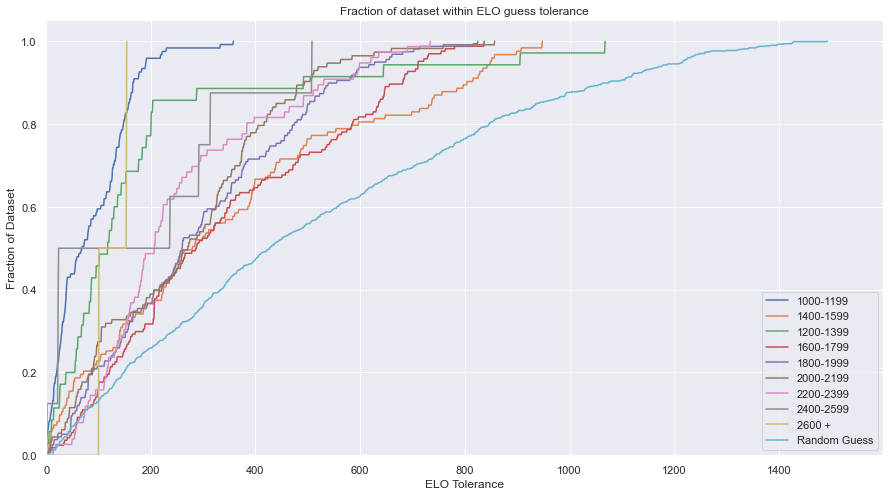

In [30]:
ax = sns.lineplot(data = ROC_Pred_Classified_Dict,dashes=False)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set(title = 'Fraction of dataset within ELO guess tolerance')
ax.set(xlabel = 'ELO Tolerance')
ax.set(ylabel = 'Fraction of Dataset')
ax.legend(loc='lower right')

<AxesSubplot:ylabel='Count'>

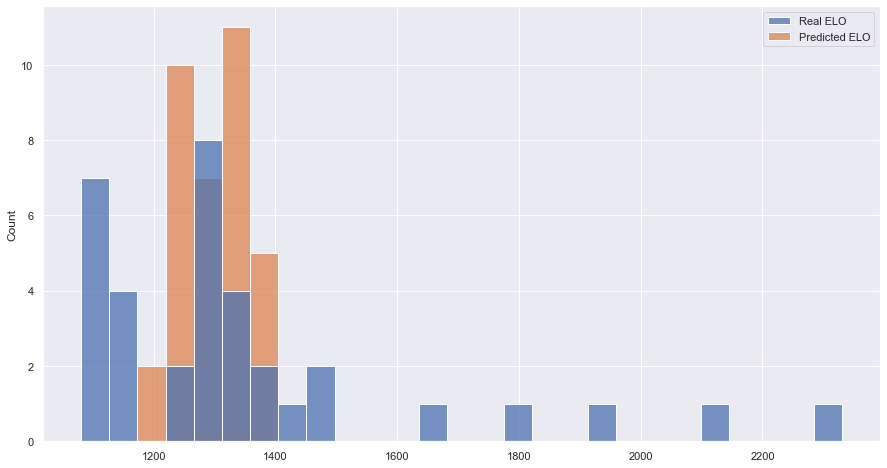

In [31]:
sns.histplot(pred_real_df[pred_real_df["Pred ELO Bracket"] == '1200-1399'])